# Multi Layer Perceptron 
* split train validation and test sets
* design model
* save best model
* test best model

#### libraries

In [2]:
import torch
import numpy as np
from torchvision import datasets # to load mnist dataset
import torchvision.transforms as transforms # dataset transformations such as totensor
from torch.utils.data.sampler import SubsetRandomSampler # random sampler

#### load, transform and split data sets

In [3]:
num_workers = 0
batch_size = 64
validation_size = 0.3
# data transformations. In this instance, test and train will have the same transformation which is not the case most often
transform = transforms.ToTensor()
# train and test sets
train_set = datasets.MNIST(root='../data',train=True,download=True, transform=transform)
test_set = datasets.MNIST(root='../data',train=False,download=False, transform=transform)

In [4]:
num_train = int(np.floor(len(train_set)*(1-validation_size)))
num_valid = int(np.floor(len(train_set)*validation_size))
print(num_valid,num_train)
ids = np.arange(len(train_set))
np.random.shuffle(ids)
# define samplers:
train_ids, validation_ids = ids[:num_train], ids[num_train:] 
print(len(train_ids),len(validation_ids))
train_sampler = SubsetRandomSampler(train_ids)
valid_sampler = SubsetRandomSampler(validation_ids)
# data loader
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, 
    num_workers=num_workers)

18000 42000
42000 18000


#### plot samples

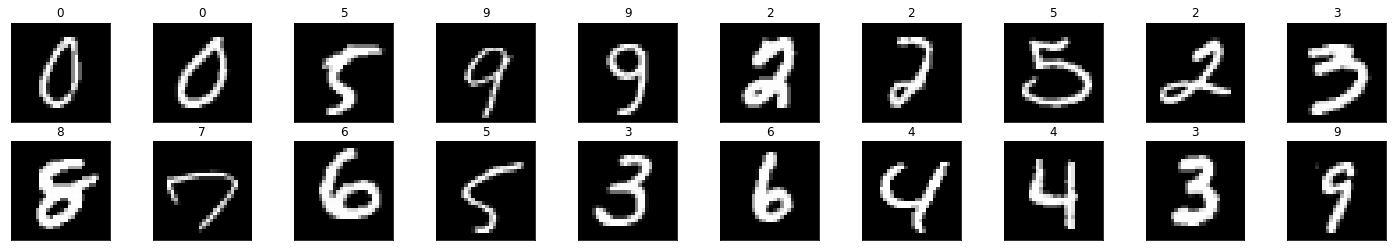

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
dataiter = iter(train_loader)
images, labels = dataiter.next() # get the batch
images = images.numpy() # convert to numpy

fig = plt.figure(figsize = (25,4))
for i in np.arange(20):
    ax = fig.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[i]),cmap='gray')
    ax.set_title(labels[i].item())

## Network

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class Network(nn.Module):
    
    def __init__(self,batch_size,flat_image_size):
        super(Network,self).__init__()
        self.batch_size = batch_size
        self.flat_image_size = flat_image_size
        #input layer
        self.fc1 = nn.Linear(28*28,128)
        # hidden layers
        self.fc2 = nn.Linear(128,64)
        self.fc3 = nn.Linear(64,32)
        self.classifier = nn.Linear(32,10)
        # dropout
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self,x):
        #reshape the image
        x = x.view(-1,self.flat_image_size)
        # network
        x = F.relu(self.fc1(x))
        #second layer
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        #third layer
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        # output layer
        x = F.log_softmax(self.classifier(x), dim=1)
        return x

In [7]:
model = Network(64, 28*28)
print(model)

Network(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (classifier): Linear(in_features=32, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


#### loss and optimiser

In [8]:
from torch import optim
criterion = nn.NLLLoss() # Loss function Negative log likelyhood loss
optimizer = optim.Adam(model.parameters(), lr=0.01) #  learning rate 0.003

In [9]:
def accuracy(y_hat_tensor,label_tensor):
    '''
    args:
        y_hat_tensor tensor: direct output of the model. 
        label_tensor tensor: actual labels of the given items
    returns:
        accuracy float
        accurate float: number of accurately labeled items
        total_samples float : number of samples investigated
    '''
    y_hat_tensor = torch.exp(y_hat_tensor)
    values, pred_labels = y_hat_tensor.max(1) # works like numpy argmax plus returns the values of the cells.
    accurate = sum(1 for a, b in zip(pred_labels.numpy(), label_tensor.numpy()) if a == b)
    total_samples = len(label_tensor)
    accuracy = accurate/total_samples
    return accuracy,accurate,total_samples

In [10]:
epochs = 10
epoch = 0
valid_loss_min = np.Inf 
train_losses = []
valid_losses = []

for e in range(epochs):
    running_loss = 0
    total_accurate = 0
    total_samples = 0
    for images, labels in train_loader:
        # Training pass
        #print(images.shape)
        output = model(images) # directly passes the images into forward method
        loss = criterion(output, labels)
        optimizer.zero_grad() # clear gradients
        loss.backward() # compute gradients
        optimizer.step() # update weights
        
        batch_train_accuracy,accurate,total_sample = accuracy(output,labels)
        running_loss += loss.item()
        total_accurate += accurate
        total_samples += total_sample
        #print(total_accurate)
    else:
        with torch.no_grad():
            model.eval()
            valid_loss = 0
            total_samples_test = 0
            total_accurate_test = 0
            for images, labels in valid_loader:
                output = model(images)
                valid_loss += criterion(output, labels)
                batch_test_accuracy,accurate_test,total_sample_test = accuracy(output,labels)
                total_accurate_test += accurate_test
                total_samples_test += total_sample_test
        model.train()
        train_losses.append(running_loss/len(train_loader))
        valid_losses.append(valid_loss/len(valid_loader))
        print('''---------- epoch : {} -----------'''.format(epoch+1))
        print(''' Training Accuracy = {}  - Training Loss = {}'''.format(total_accurate/total_samples,running_loss/len(train_loader)))
        print(''' Test Accuracy = {}  - Test Loss = {}'''.format(total_accurate_test/total_samples_test,valid_loss/len(valid_loader)))
        epoch += 1
        print(valid_loss/len(valid_loader))
        print(valid_loss_min)
        if valid_loss/len(valid_loader)<valid_loss_min:
            valid_loss_min = valid_loss/len(valid_loader)
            print('validation loss decreased! Saving model..')
            torch.save(model.state_dict(), '../models/model_9.pt')
            

---------- epoch : 1 -----------
 Training Accuracy = 0.8858571428571429  - Training Loss = 0.4003699090915819
 Test Accuracy = 0.9433888888888889  - Test Loss = 0.2006707787513733
tensor(0.2007)
inf
validation loss decreased! Saving model..
---------- epoch : 2 -----------
 Training Accuracy = 0.9413571428571429  - Training Loss = 0.23330283287630518
 Test Accuracy = 0.9547222222222222  - Test Loss = 0.1671222746372223
tensor(0.1671)
tensor(0.2007)
validation loss decreased! Saving model..
---------- epoch : 3 -----------
 Training Accuracy = 0.9457857142857143  - Training Loss = 0.2083977587064629
 Test Accuracy = 0.9576666666666667  - Test Loss = 0.1852959543466568
tensor(0.1853)
tensor(0.1671)
---------- epoch : 4 -----------
 Training Accuracy = 0.9511904761904761  - Training Loss = 0.19451083942023042
 Test Accuracy = 0.9594444444444444  - Test Loss = 0.17316097021102905
tensor(0.1732)
tensor(0.1671)
---------- epoch : 5 -----------
 Training Accuracy = 0.9571190476190476  - Trai

#### load the best model

In [16]:
model.load_state_dict(torch.load('../models/model_9.pt'))

<All keys matched successfully>

## Test 

In [12]:
with torch.no_grad():
            model.eval()
            test_loss = 0
            total_samples_test = 0
            total_accurate_test = 0
            for images, labels in test_loader:
                output = model(images)
                test_loss += criterion(output, labels)
                batch_test_accuracy,accurate_test,total_sample_test = accuracy(output,labels)
                total_accurate_test += accurate_test
                total_samples_test += total_sample_test

In [13]:
loss = test_loss/len(test_loader)
print(loss)

tensor(0.1530)


In [14]:
print(total_accurate_test/total_samples_test)

0.9565
